## TP1 Physique des marchés : faits stylisés

*Notebook réalisé par Alexandre Boistard, Ethan Trentin*

### 2. Obtenir des données
#### 2.1 Données journalières

In [65]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.distributions.empirical_distribution import ECDF
import sys

[*********************100%***********************]  1 of 1 completed


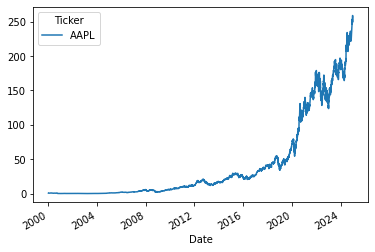

In [56]:
AAPL_daily = yf.download('AAPL', start='2000-01-01', end='2025-01-01')
AAPL_daily['Close'].plot()
plt.show()

In [57]:
AAPL_daily

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2000-01-03,0.842151,0.846382,0.765036,0.789017,535796800
2000-01-04,0.771149,0.832276,0.761274,0.814408,512377600
2000-01-05,0.782433,0.831806,0.774910,0.780552,778321600
2000-01-06,0.714722,0.805003,0.714722,0.798421,767972800
2000-01-07,0.748578,0.759864,0.718485,0.726008,460734400
...,...,...,...,...,...
2024-12-24,257.916443,257.926411,255.009620,255.209412,23234700
2024-12-26,258.735504,259.814335,257.347047,257.906429,27237100


#### 2.2 Données intraday

In [58]:
def load_TRTH_bbo(filename,
             tz_exchange="America/New_York",
             open_time="09:30:00",
             close_time="16:00:00",
             only_regular_trading_hours=True):
    
    DF = pd.read_csv(filename)

    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time(open_time,close_time)    # warning: ever heard e.g. about Thanksgivings?
        
    return DF

In [59]:
Path = sys.path[0]
AAPL_intraday = load_TRTH_bbo(Path+"\\2017-01-03-AAPL.OQ-bbo.csv.gz")
AAPL_intraday

,bid-price,bid-volume,ask-price,ask-volume
xltime,,,,
2017-01-03 09:30:00.074000384-05:00,115.81,5,115.82,415
2017-01-03 09:30:00.074000384-05:00,115.80,4,115.82,415
2017-01-03 09:30:00.083000832-05:00,115.80,18,115.82,415
2017-01-03 09:30:00.093000448-05:00,115.80,18,115.82,475
2017-01-03 09:30:00.113000192-05:00,115.80,18,115.82,474
...,...,...,...,...
2017-01-03 16:00:00-05:00,116.13,234,116.15,11
2017-01-03 16:00:00-05:00,116.13,173,116.15,11
2017-01-03 16:00:00-05:00,116.13,169,116.15,11


### 3. Calcul des rendements
#### 3.1 Données journalières

In [60]:
# Ici les prix sont ajustés automatiquement donc on va calculer
# les log-rendements sur la colonne "Close"
AAPL_daily["Log Returns"] = np.log(AAPL_daily['Close']).diff().values
AAPL_daily = AAPL_daily.dropna()
AAPL_daily

Price,Close,High,Low,Open,Volume,Log Returns
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,
Date,,,,,,
2000-01-04,0.771149,0.832276,0.761274,0.814408,512377600,-0.088077
2000-01-05,0.782433,0.831806,0.774910,0.780552,778321600,0.014527
2000-01-06,0.714722,0.805003,0.714722,0.798421,767972800,-0.090514
2000-01-07,0.748578,0.759864,0.718485,0.726008,460734400,0.046281
2000-01-10,0.735413,0.769267,0.712842,0.767387,505064000,-0.017744
...,...,...,...,...,...,...
2024-12-24,257.916443,257.926411,255.009620,255.209412,23234700,0.011413
2024-12-26,258.735504,259.814335,257.347047,257.906429,27237100,0.003171


#### 3.2 Données intraday 

In [61]:
# On considère le stock Apple donc les marchés Américains. Dans la fonction 
# load_TRTH_bbo, on a donc utilisé les horaires du marché, entre 9h30 et 16h 
# pour extraire les données. 
# On calcule dans un premier temps la colonne de prix moyen mid
AAPL_intraday["Mid"] = (AAPL_intraday["bid-price"] + AAPL_intraday["ask-price"])/2
# On calcule ensuite les rendements sur la colonne "Mid"
AAPL_intraday["Returns"] = (AAPL_intraday["Mid"]).diff().values
AAPL_intraday = AAPL_intraday.dropna(subset=["Returns"])  
AAPL_intraday

,bid-price,bid-volume,ask-price,ask-volume,Mid,Returns
xltime,,,,,,
2017-01-03 09:30:00.074000384-05:00,115.80,4,115.82,415,115.81,-0.005
2017-01-03 09:30:00.083000832-05:00,115.80,18,115.82,415,115.81,0.000
2017-01-03 09:30:00.093000448-05:00,115.80,18,115.82,475,115.81,0.000
2017-01-03 09:30:00.113000192-05:00,115.80,18,115.82,474,115.81,0.000
2017-01-03 09:30:00.164000-05:00,115.80,18,115.82,448,115.81,0.000
...,...,...,...,...,...,...
2017-01-03 16:00:00-05:00,116.13,234,116.15,11,116.14,0.000
2017-01-03 16:00:00-05:00,116.13,173,116.15,11,116.14,0.000
2017-01-03 16:00:00-05:00,116.13,169,116.15,11,116.14,0.000


In [62]:
# On resample à 5 secondes pour avoir un dataset plus lisible et on calcule les log
# rendements sur la colonne "Mid"
AAPL_intraday_resampled = AAPL_intraday.resample("5S").last()
AAPL_intraday_resampled["Log Returns"] = np.log(AAPL_intraday_resampled["Mid"]).diff().values
AAPL_intraday_resampled = AAPL_intraday_resampled.dropna(subset=["Log Returns"])
AAPL_intraday_resampled 

,bid-price,bid-volume,ask-price,ask-volume,Mid,Returns,Log Returns
xltime,,,,,,,
2017-01-03 09:30:05-05:00,115.70,5.0,115.77,2.0,115.735,0.000,-0.000346
2017-01-03 09:30:10-05:00,115.71,2.0,115.75,3.0,115.730,0.000,-0.000043
2017-01-03 09:30:15-05:00,115.56,2.0,115.73,1.0,115.645,0.025,-0.000735
2017-01-03 09:30:20-05:00,115.50,31.0,115.69,2.0,115.595,0.000,-0.000432
2017-01-03 09:30:25-05:00,115.57,2.0,115.67,2.0,115.620,0.000,0.000216
...,...,...,...,...,...,...,...
2017-01-03 15:59:40-05:00,115.98,2.0,115.99,11.0,115.985,0.000,0.000000
2017-01-03 15:59:45-05:00,115.93,3.0,115.94,4.0,115.935,0.000,-0.000431
2017-01-03 15:59:50-05:00,116.04,5.0,116.06,2.0,116.050,0.000,0.000991


### 4. Analyse empirique
#### 4.1 Rendements : types de distribution

*Les questions suivantes seront traitées à la fois sur les données journalières et sur les données intraday.*

*1. Dans un premier temps, nous allons tester la gaussianité des rendements.*

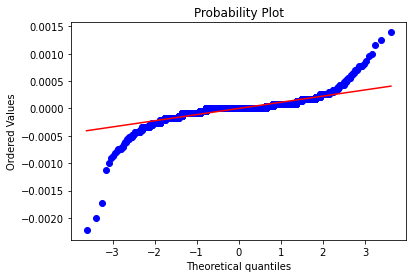

In [63]:
# On affiche un QQ-plot pour tester la gaussianité des log-rendements des prix intradays
stats.probplot(AAPL_intraday_resampled["Log Returns"], dist="norm", plot=plt)
plt.show()

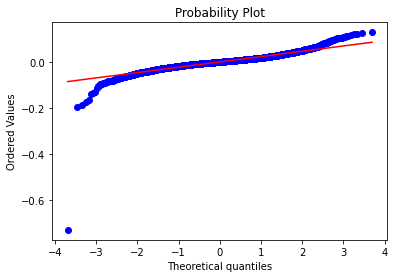

In [64]:
# On affiche un QQ-plot pour tester la gaussianité des log-rendements des prix journaliers
stats.probplot(AAPL_daily["Log Returns"], dist="norm", plot=plt)
plt.show()

Ainsi, nous pouvons constater que les deux QQ-plots ne sont pas ceux d'une loi normale étant donné que les points ne suivent pas la droite.

Cependant, le premier QQ-plot représente mieux une loi normale que le second, car ses extrêmes sont plus contenus malgré un léger effet de kurtosis et la plupart des points restent alignés avec la droite rouge. Le deuxième QQ-plot montre une déviation plus forte, indiquant une distribution encore moins gaussienne.

Ceci est probablement dû au fait que les rendements financiers ont souvent des distributions leptokurtiques, avec des événements extrêmes plus fréquemment attendu que pour une distribution gaussienne (queues lourdes).

*2. Dans un second temps, nous allons déterminer graphiquement si la distribution de la valeur absolue des rendements a une queue lourde.*

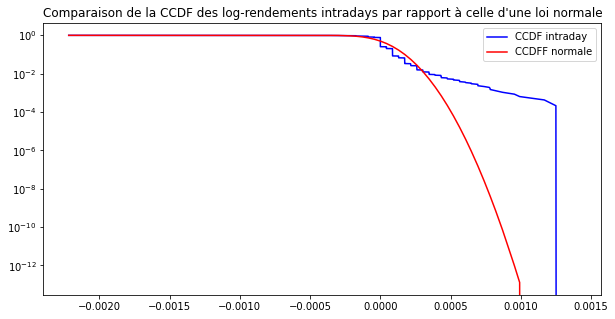

In [99]:
# a. On trace la fonction complémentaire de la distribution cumulée (ccdf ou survivor function) avec des axes linéaires en X et log en Y. 
# Si on trouve une concavité, c'est un signe de la trace d'une queue lourde.
ecdf_intraday = ECDF(AAPL_intraday_resampled["Log Returns"])
plt.figure(figsize=(10,5))
plt.plot(ecdf_intraday.x, 1-ecdf_intraday.y, color = "blue", label = "CCDF intraday")
plt.plot(ecdf_intraday.x, 1-stats.norm.cdf(ecdf_intraday.x,loc=AAPL_intraday_resampled["Log Returns"].mean(),scale=AAPL_intraday_resampled["Log Returns"].std()), color = "red", label ="CCDFF normale")
plt.yscale("log")
plt.title("Comparaison de la CCDF des log-rendements intradays par rapport à celle d'une loi normale")
plt.legend()
plt.show()

On se rend compte que la CCDF décroit de 0 à 1 ce qui est cohérent puisqu'elle représente $P(r>x)$, soit la probabilité d'avoir un rendement supérieur à une certaine valeur. La décroissance est en marche et non lisse puisqu'on a un nombre limité de valeurs.

La décroissance plus faible qu'une loi normale sur la partie droite du graph indique la présence de queues lourdes. 

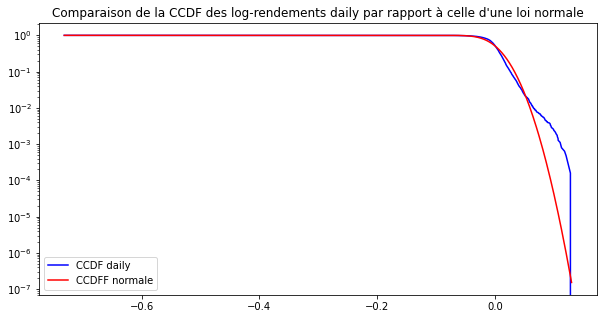

In [102]:
ecdf_daily = ECDF(AAPL_daily["Log Returns"])
plt.figure(figsize=(10,5))
plt.plot(ecdf_daily.x, 1-ecdf_daily.y, color = "blue", label = "CCDF daily")
plt.plot(ecdf_daily.x, 1-stats.norm.cdf(ecdf_daily.x,loc=AAPL_daily["Log Returns"].mean(),scale=AAPL_daily["Log Returns"].std()), color = "red", label ="CCDFF normale")
plt.yscale("log")
plt.title("Comparaison de la CCDF des log-rendements daily par rapport à celle d'une loi normale")
plt.legend()
plt.show()

Déjà, remarquons la différence sur la granularité des données : en intraday, on avait un nombre limité de valeurs dû au fait que les rendements possibles sont contraints par la fréquence d'échantillonage et la microstructure du marché. Donc la CCDF n'est pas parfaitement lisse et forme des paliers. 

Au contraire, au niveau des rendements daily, on a accumulé du fait de l'historique de 25 ans de données beaucoup de valeurs différentes donnant une distribution plus continue et donc plus lisse. Les effets journaliers sont donc moins contraints par la microstructure du marché. 

Ensuite, on remarque que la décroissance de la CCDF des rendements daily est moins importante que celle de la loi normale sur une partie des données, montrant la présence de queues lourdes. Cependant, ces queues sont beaucoup moins marquées que pour les rendements intradays.

*b. Nous allons maintenant tracer le QQ-plot de $\frac{|r|}{E(|r|)}$ avec une distribution exponentielle de moyenne 1 comme distribution théorique.*